# Machine Learning Capstone: YouTube Facial Recognition Using Landmarks
***

This dataset is a processed version of the YouTube Faces Dataset, that contained short videos of celebrities that are publicly available and downloaded from YouTube. There are multiple videos of each celebrity (up to 6 videos per celebrity). The original videos were cropped around the faces and only 240 consecutive frames were kept for each original video. 
The dataset is available here: https://www.kaggle.com/selfishgene/youtube-faces-with-facial-keypoints

This is the **2nd of 3 Notebooks** containing a comparison of possible models built to perform facial recognition of the facial landmarks provided in teh dataset.

**Notebook 1: YouTubeFacialRecognition.ipynb**  
    - Contains all the mothods used on the subset data (youtube_faces_with_keypoints_small.csv) provided on Kaggle)
**Notebook 2: YouTubeFacialRecognitionBig.ipynb** 
    - Contains clustering and classification methods on the full dataset (youtube_faces_with_keypoints_large.csv)
**Notebook 3: YouTubeFacialRecognitionBig-ANNs.ipynb** 
    - Contains roughly optimized neural networks on both the 2D and 3D landmarks

Supporting documents: 
- two .csv files containing the full list and a subset list of the file names and number of frames for each video file
- the corresponding .npz files containing the rgb color image frame, the bouding box and 2D and 3D landmark coordinates
- my stacked cleverly named 'export_dataframe.csv' file with each frame given a line in the table with the name of the person, the frame number and label encoding, to save you some time!
- a model final model for a small dataset (best_modelsmall7.h5) and a model for the large dataset (best_model_3D4.h5)

References:
Lior Wolf, Tal Hassner and Itay Maoz 
Face Recognition in Unconstrained Videos with Matched Background Similarity. 
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), 2011. (pdf)

2D and 3D keypoints, from the following paper: 
<br>Adrian Bulat and Georgios Tzimiropoulos. 
How far are we from solving the 2D & 3D Face Alignment problem? 
(and a dataset of 230,000 3D facial landmarks), arxiv, 2017. (pdf)

## Import Libraries

In [9]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import glob
from sklearn import cluster
import seaborn as sns

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split
import itertools

#early stopping plugin
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## Load the data set: 
This dataset is a processed version of the YouTube Faces Dataset, that basically contained short videos of celebrities that are publicly available and were downloaded from YouTube. There are multiple videos of each celebrity (up to 6 videos per celebrity). I've cropped the original videos around the faces, plus kept only consecutive frames of up to 240 frames for each original video. This is done also for reasons of disk space, but mainly to make the dataset easier to use.
The dataset is available here: https://www.kaggle.com/selfishgene/youtube-faces-with-facial-keypoints

References:
Lior Wolf, Tal Hassner and Itay Maoz 
Face Recognition in Unconstrained Videos with Matched Background Similarity. 
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), 2011. (pdf)

2D and 3D keypoints, from the following paper: 
<br>Adrian Bulat and Georgios Tzimiropoulos. 
How far are we from solving the 2D & 3D Face Alignment problem? 
(and a dataset of 230,000 3D facial landmarks), arxiv, 2017. (pdf)

In [10]:
videoDF = pd.read_csv('youtube_faces_with_keypoints_large.csv')
videoDF.head(5)

videoID     personName  imageHeight  imageWidth  videoDuration  \
0  Alison_Lohman_0  Alison_Lohman        228.0       213.0          240.0   
1  Alison_Lohman_1  Alison_Lohman        248.0       201.0           79.0   
2  Alison_Lohman_2  Alison_Lohman        335.0       308.0          136.0   
3  Alison_Lohman_3  Alison_Lohman        151.0       110.0           53.0   
4  Alison_Lohman_4  Alison_Lohman        236.0       228.0          147.0   

   averageFaceSize  numVideosForPerson  
0        90.150000                 6.0  
1       108.417722                 6.0  
2       122.161765                 6.0  
3        58.000000                 6.0  
4        91.680272                 6.0

In [11]:
videoDF.describe()

imageHeight   imageWidth  videoDuration  averageFaceSize  \
count  1293.000000  1293.000000    1293.000000      1293.000000   
mean    210.156226   194.787316     120.309358        94.475845   
std      65.799033    68.650709      72.413353        37.032520   
min      81.000000    72.000000      42.000000        35.348837   
25%     163.000000   144.000000      59.000000        66.791045   
50%     201.000000   185.000000      91.000000        87.280702   
75%     244.000000   234.000000     187.000000       114.163636   
max     478.000000   494.000000     240.000000       243.609195   

       numVideosForPerson  
count         1293.000000  
mean             3.583140  
std              0.729897  
min              3.000000  
25%              3.000000  
50%              3.000000  
75%              4.000000  
max              6.000000

## Dataset Overview:

In [12]:
#Count the number of still images
videoDF.videoDuration.sum()

155560.0

In [13]:
#Number of unique people
categories = len(videoDF.personName.unique())
nameList = videoDF.personName.unique()
numList = np.arange(0,categories)
print("There are", categories, 'unique people in the dataset')
#print(nameList)
#print(numList),print(len(numList))

There are 374 unique people in the dataset


In [14]:
# Number of people in dataset
groupedByPerson = videoDF.groupby("personName")
numVidsPerPerson = groupedByPerson.count()['videoID']
groupedByPerson.count().sort_values('videoID', axis=0, ascending=False)

videoID  imageHeight  imageWidth  videoDuration  \
personName                                                                   
Kevin_Spacey                     6            6           6              6   
Robert_F_Kennedy_Jr              6            6           6              6   
Alison_Lohman                    6            6           6              6   
Lauren_Hutton                    6            6           6              6   
Narendra_Modi                    5            5           5              5   
Tara_VanDerveer                  5            5           5              5   
Barbara_Brezigar                 5            5           5              5   
Mary_Matalin                     5            5           5              5   
Newt_Gingrich                    5            5           5              5   
Nicanor_Duarte_Frutos            5            5           5              5   
George_W_Bush                    5            5           5              5   
Norm_Macdonald                   5            5           5              5   
Tavis_Smiley                     5            5           5              5   
Fred_Eckhard                     5            5           5              5   
Kim_Gandy                        5            5           5              5   
Paul_Bremer                      5            5           5              5   
Paul_Celluci                     5            5           5              5   
Phil_Gramm                       5            5           5              5   
Robert_Nardelli                  5            5           5              5   
Elizabeth_Berkeley               5            5           5              5   
Richard_Shelby                   5            5           5              5   
Richard_Rodriguez                5            5           5              5   
Ray_Romano                       5            5           5              5   
Andrew_Bernard                   5            5           5              5   
Daniel_Kurtzer                   5            5           5              5   
Amanda_Beard                     5            5           5              5   
Maria_Bello                      5            5           5              5   
Emilio_Botin                     4            4           4              4   
Emma_Thompson                    4            4           4              4   
Linda_Franklin                   4            4           4              4   
...                            ...          ...         ...            ...   
Fernando_Sanz                    3            3           3              3   
Fernando_Henrique_Cardoso        3            3           3              3   
Eunice_Barber                    3            3           3              3   
Estelle_Morris                   3            3           3              3   
Erin_Hershey_Presley             3            3           3              3   
Isabelle_Huppert                 3            3           3              3   
Eric_Benet                       3            3           3              3   
Emma_Nicholson                   3            3           3              3   
Emile_Lahoud                     3            3           3              3   
Elsa_Zylberstein                 3            3           3              3   
Elmar_Brok                       3            3           3              3   
Ellen_DeGeneres                  3            3           3              3   
Florecita_Cobian                 3            3           3              3   
Frances_Fisher                   3            3           3              3   
Frank_Beamer                     3            3           3              3   
Frank_Keating                    3            3           3              3   
Frank_Solich                     3            3           3              3   
GL_Peiris                        3            3           3              3   
Gary_Bettman                     3            3  

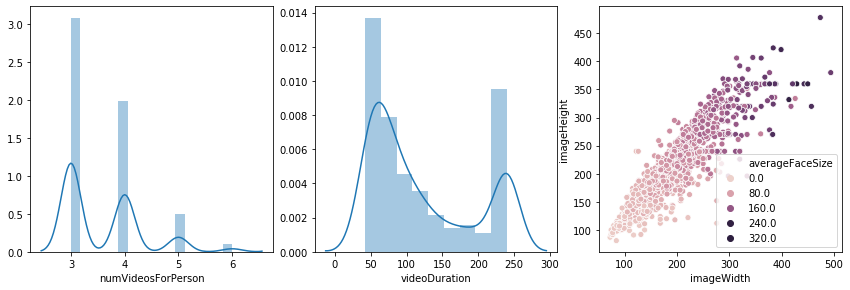

In [15]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(12, 4)
f.tight_layout()


sns.distplot(videoDF['numVideosForPerson'],  ax=axes[0])

sns.distplot(videoDF["videoDuration"],  ax=axes[1])

sns.scatterplot(y="imageHeight", x= "imageWidth", 
                data=videoDF, hue = 'averageFaceSize', legend = 'brief',ax=axes[2])

## Locate the Video Files for Use

Glob is an extension of Python that assigns a filepath to each file in a given directory so that it can be called by the program.

In [16]:
npzFilesFullPath = glob.glob('*.npz')

In [17]:
# remove the .npz file extension
videoIDs = [x.split('/')[-1].split('.')[0] for x in npzFilesFullPath]

In [18]:
# create a dictionary to call the videos, key is the file name in teh dataframe, value is the filepath
fullPaths = {}
for videoID, fullPath in zip(videoIDs, npzFilesFullPath):
    fullPaths[videoID] = fullPath

## Display still frames from the videos
adapted from the original kernal https://www.kaggle.com/selfishgene/exploring-youtube-faces-with-keypoints-dataset

In [19]:
np.random.seed(0)
numVideos = 4
framesToShowFromVideo = np.array([0.1,0.5,0.9])
numFramesPerVideo = len(framesToShowFromVideo)

In [20]:
randVideoIDs = videoDF.loc[np.random.choice(videoDF.index,size=numVideos,replace=False),'videoID']
print(randVideoIDs)

662     Bianca_Jagger_4
474      Marina_Silva_5
1255     Tom_Sizemore_1
240        Clay_Aiken_3
Name: videoID, dtype: object


In [21]:
# define which points need to be connected with a line
jawPoints          = [ 0,17]
rigthEyebrowPoints = [17,22]
leftEyebrowPoints  = [22,27]
noseRidgePoints    = [27,31]
noseBasePoints     = [31,36]
rightEyePoints     = [36,42]
leftEyePoints      = [42,48]
outerMouthPoints   = [48,60]
innerMouthPoints   = [60,68]

listOfAllConnectedPoints = [jawPoints,rigthEyebrowPoints,leftEyebrowPoints,
                            noseRidgePoints,noseBasePoints,
                            rightEyePoints,leftEyePoints,outerMouthPoints,innerMouthPoints]

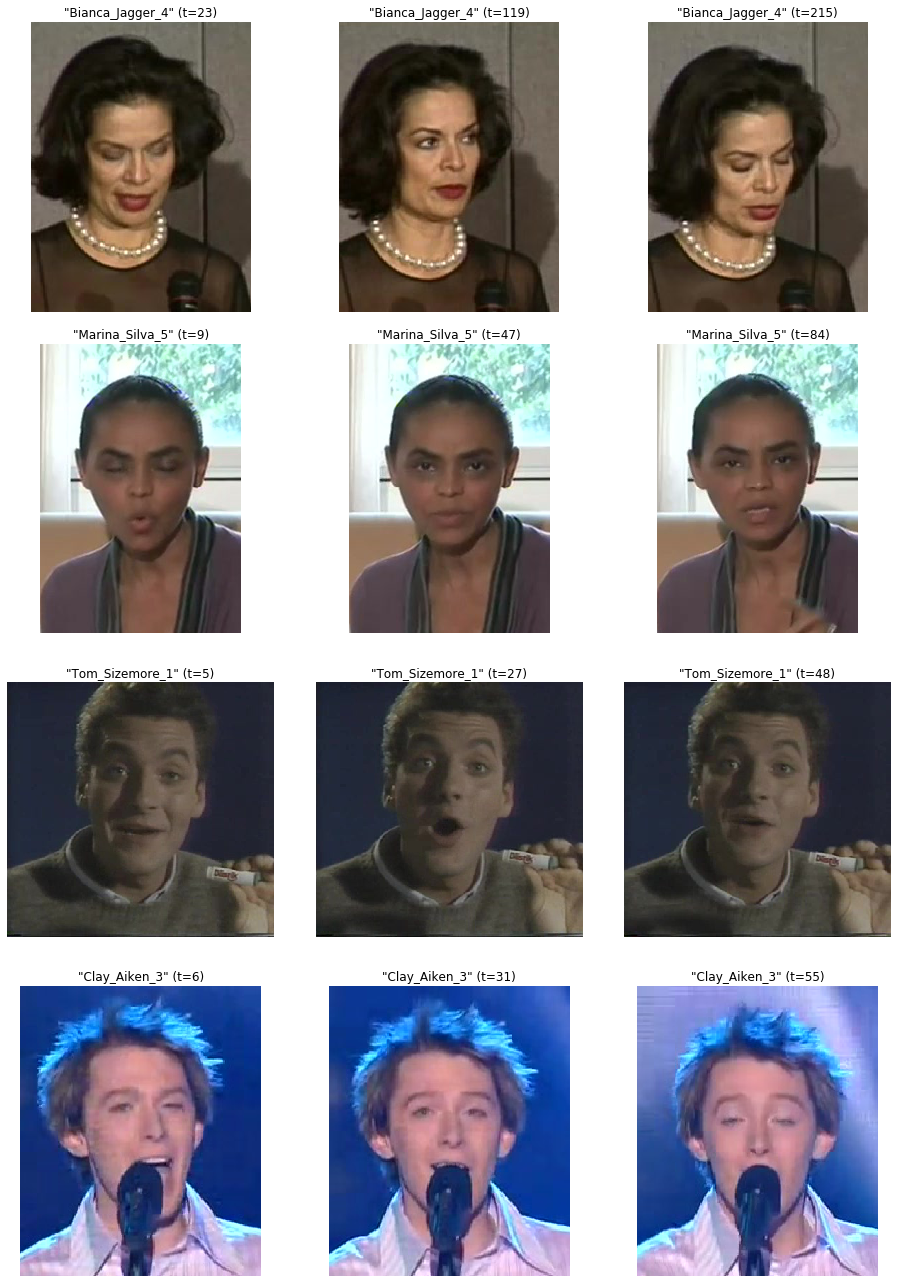

In [22]:
fig, axArray = plt.subplots(nrows=numVideos,ncols=numFramesPerVideo,figsize=(13,18))
fig.tight_layout()

for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages'] # arrays of the image colour values

    # select frames and show their content
    selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        axArray[i][j].imshow(colorImages[:,:,:,frameInd])
        axArray[i][j].set_title('"%s" (t=%d)' %(videoID,frameInd), fontsize=12)
        axArray[i][j].set_axis_off()

## Add the 2D facial recognition markers

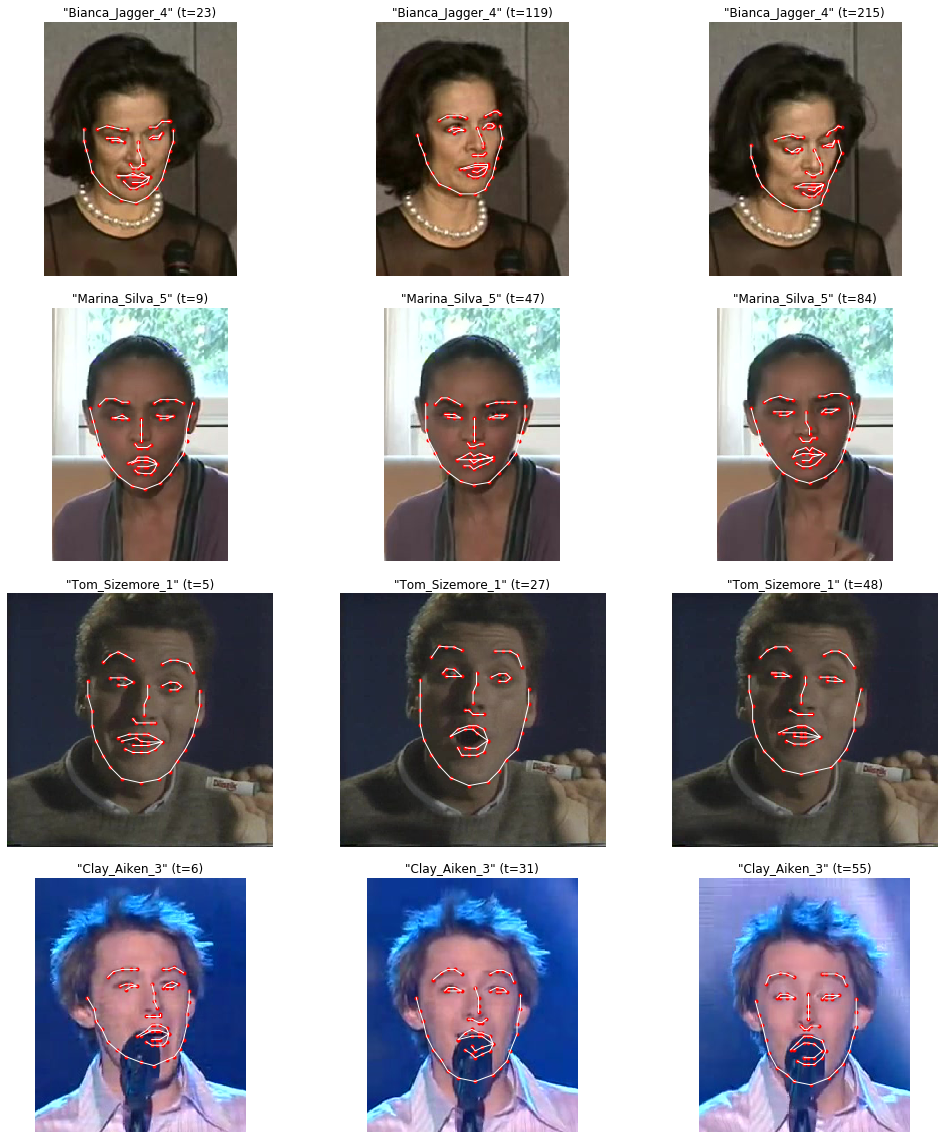

In [23]:
fig, axArray = plt.subplots(nrows=numVideos,ncols=numFramesPerVideo,figsize=(14,16))
fig.tight_layout()

for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages'] # arrays of the image colour values
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']

    # select frames and show their content with the landmark points
    selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        axArray[i][j].imshow(colorImages[:,:,:,frameInd])
        axArray[i][j].scatter(x=landmarks2D[:,0,frameInd],y=landmarks2D[:,1,frameInd],s=9,c='r')
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks2D[conPts[0]:conPts[-1],0,frameInd]
            yPts = landmarks2D[conPts[0]:conPts[-1],1,frameInd]
            axArray[i][j].plot(xPts,yPts,c='w',lw=1)
        axArray[i][j].set_title('"%s" (t=%d)' %(videoID,frameInd), fontsize=12)
        axArray[i][j].set_axis_off()

## This package also allows you to view the facial recognition markers in 3D

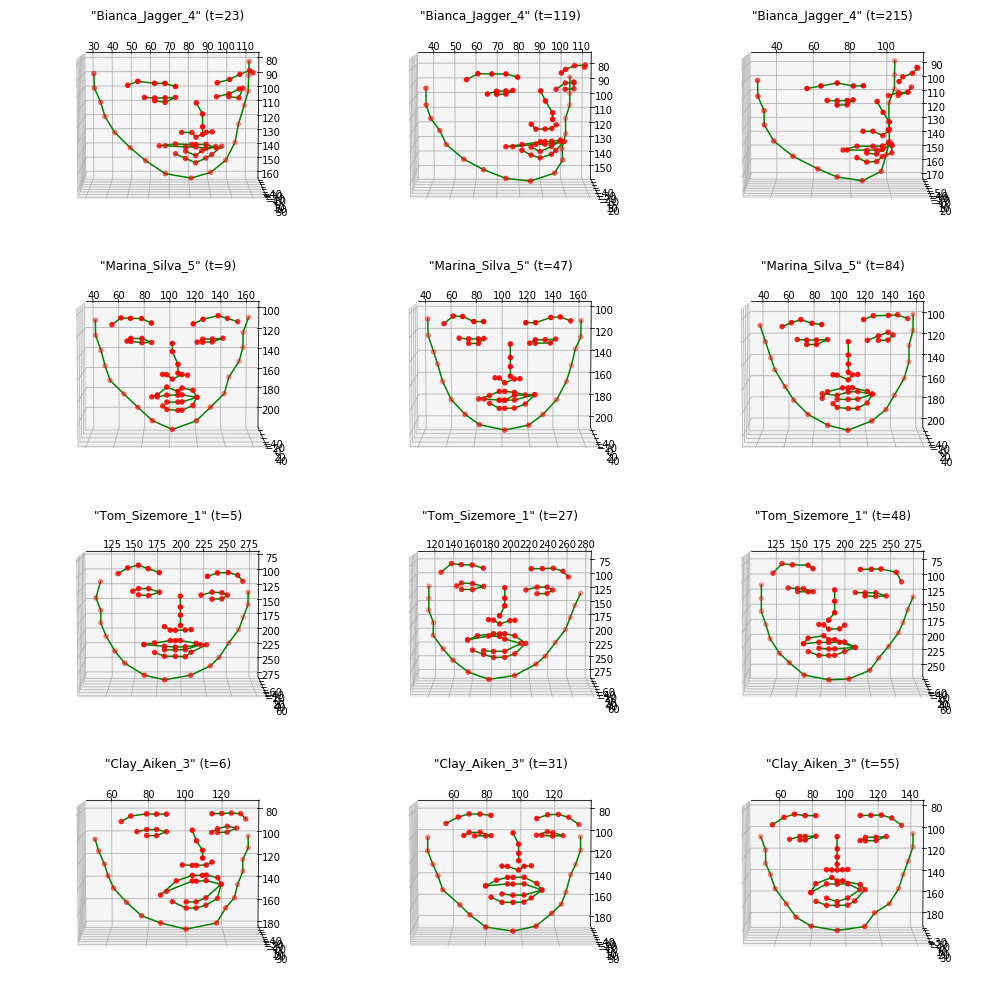

In [24]:
# show several 3D keypoints

fig = plt.figure(figsize=(14,14))
for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages']
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']

    # select frames and show their content
    selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        subplotInd = i*numFramesPerVideo + j+1
        ax = fig.add_subplot(numVideos, numFramesPerVideo, subplotInd, projection='3d')
        ax.scatter(landmarks3D[:,0,frameInd], landmarks3D[:,1,frameInd], landmarks3D[:,2,frameInd],c='r')
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks3D[conPts[0]:conPts[-1],0,frameInd]
            yPts = landmarks3D[conPts[0]:conPts[-1],1,frameInd]
            zPts = landmarks3D[conPts[0]:conPts[-1],2,frameInd]
            ax.plot3D(xPts,yPts,zPts,color='g')         
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.view_init(elev=96, azim=90)
        ax.set_title('"%s" (t=%d)' %(videoID,frameInd), fontsize=12)
        
plt.tight_layout()

## Initiate Exploratory Data Analysis on the landmark points to compare images

Collect all of the 2D and 3D shapes from all frames from all videos and save to a single numpy array matrix

In [25]:
totalNumberOfFrames = int(videoDF['videoDuration'].sum())
print('Total number of frames in dataset: ',totalNumberOfFrames)

#Initialize arrarys for the landmark points for each frame in the dataset
landmarks2D_all = np.zeros((68,2,int(totalNumberOfFrames)))
landmarks3D_all = np.zeros((68,3,int(totalNumberOfFrames)))

print(landmarks2D_all.shape)
print(landmarks3D_all.shape)


shapeIndToVideoID = {} # dictionary for later useage
endInd = 0

# Add the frames to the arrays
for i, videoID in enumerate(videoDF['videoID']):
    
    # load video
    videoFile = np.load(fullPaths[videoID])
    #print(videoFile)
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']
    
    startInd = endInd
    endInd   = startInd + landmarks2D.shape[2]

    # store in one big array
    landmarks2D_all[:,:,startInd:endInd] = landmarks2D
    landmarks3D_all[:,:,startInd:endInd] = landmarks3D
    
    # make sure we keep track of the mapping to the original video and frame
    for videoFrameInd, shapeInd in enumerate(range(startInd,endInd)):
        shapeIndToVideoID[shapeInd] = (videoID, videoFrameInd)
    

Total number of frames in dataset:  155560
(68, 2, 155560)
(68, 3, 155560)


## Normalize the landmarks so they can be compared

Normalization code also from https://www.kaggle.com/selfishgene/exploring-youtube-faces-with-keypoints-dataset

In [26]:
# center the shapes around zero
# i.e. such that for each frame the mean x,y,z coordinates will be zero
# or in math terms: Xc = X - mean(X), Yc = Y - mean(Y), Zc = Z - mean(Z)
landmarks2D_centered = np.zeros(landmarks2D_all.shape)
landmarks2D_centered = landmarks2D_all - np.tile(landmarks2D_all.mean(axis=0),[68,1,1])

landmarks3D_centered = np.zeros(landmarks3D_all.shape)
landmarks3D_centered = landmarks3D_all - np.tile(landmarks3D_all.mean(axis=0),[68,1,1])

# normalize the shapes such that they have the same scale
# i.e. such that for each frame the mean euclidian distance from the shape center will be one
# or in math terms: mean( sqrt(dX^2 + dY^2 + dZ^2) ) = 1 
landmarks2D_normlized = np.zeros(landmarks2D_all.shape)
landmarks2D_normlized = landmarks2D_centered / np.tile(np.sqrt((landmarks2D_centered**2).sum(axis=1)).mean(axis=0), [68,2,1])

landmarks3D_normlized = np.zeros(landmarks3D_all.shape)
landmarks3D_normlized = landmarks3D_centered / np.tile(np.sqrt((landmarks3D_centered**2).sum(axis=1)).mean(axis=0), [68,3,1])

## Visualize the normalizations

Text(0.5, 1.0, 'Normlized Shapes')

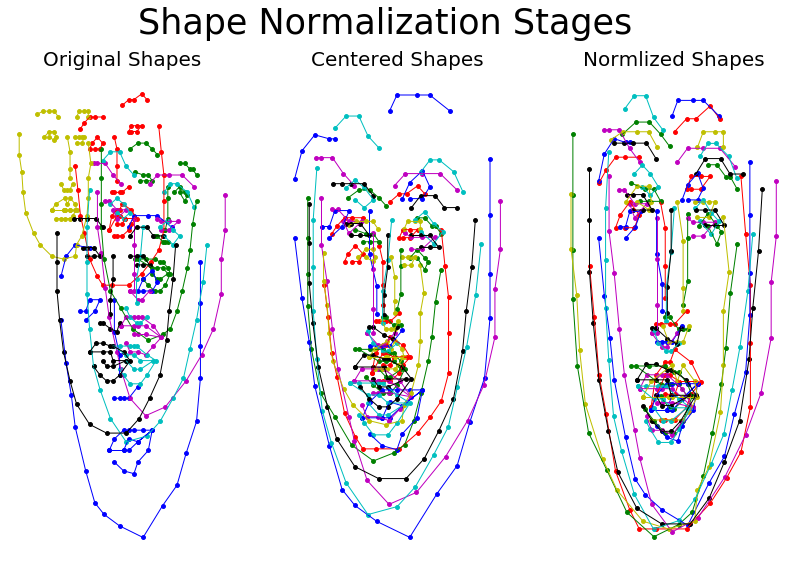

In [27]:
#%% check the 2D normalization and verify that everything is as expected
# select random several frames to be used as test cases
np.random.seed(2)

listOfShapeColors = ['r','g','b','m','y','c','k']
numShapesToPresent = len(listOfShapeColors)
listOfShapeInds = np.random.choice(range(int(totalNumberOfFrames)),size=numShapesToPresent,replace=False)

#plt.close('all') (not sure what this line is for, closes the plot windows, I suppose if you have in a different IDE)

plt.figure(figsize=(14,9))
plt.suptitle('Shape Normalization Stages',fontsize=35) # main figure box setup and title

plt.subplot(1,3,1)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_all[:,0,shapeInd], -landmarks2D_all[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_all[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_all[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); 
plt.title('Original Shapes', fontsize=20)

plt.subplot(1,3,2)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_centered[:,0,shapeInd], -landmarks2D_centered[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_centered[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_centered[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Centered Shapes', fontsize=20)

plt.subplot(1,3,3)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_normlized[:,0,shapeInd], -landmarks2D_normlized[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_normlized[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_normlized[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Normlized Shapes', fontsize=20)

## Perform Cluster Analysis 
We are going to use the landmarked points on each of the still frames to attempt to create clusters of unique individuals.

In [28]:
# Check the shape of our input array
landmarks2D_normlized.shape

(68, 2, 155560)

In [29]:
#%% cluster normalized shapes and show the cluster centers
normalizedShapesTable = np.reshape(landmarks2D_normlized, [68*2, landmarks2D_normlized.shape[2]]).T


Save the scores of each model as we increase the number of clusters to find the optimum number of groups

# Perform a cluster analysis on an increasing number of nearest neighbours 

Plot the number of neighbours by the error rate, the inflexion suggests the optimum number of clusters

In [30]:
scores = []

for numClusters in range(1, 16):
    shapesModel = cluster.KMeans(n_clusters=numClusters, n_init=5, random_state=1).fit(normalizedShapesTable[::2,:])
    clusterAssignment = shapesModel.predict(normalizedShapesTable)
    scores.append(shapesModel.inertia_)
    print('Cluster "%f" complete' %(numClusters))
       

Cluster "1.000000" complete
Cluster "2.000000" complete
Cluster "3.000000" complete
Cluster "4.000000" complete
Cluster "5.000000" complete
Cluster "6.000000" complete
Cluster "7.000000" complete
Cluster "8.000000" complete
Cluster "9.000000" complete
Cluster "10.000000" complete
Cluster "11.000000" complete
Cluster "12.000000" complete
Cluster "13.000000" complete
Cluster "14.000000" complete
Cluster "15.000000" complete


Plot the scores to utilize the "Elbow Method" to locate the optimum 

Text(0, 0.5, 'SSE')

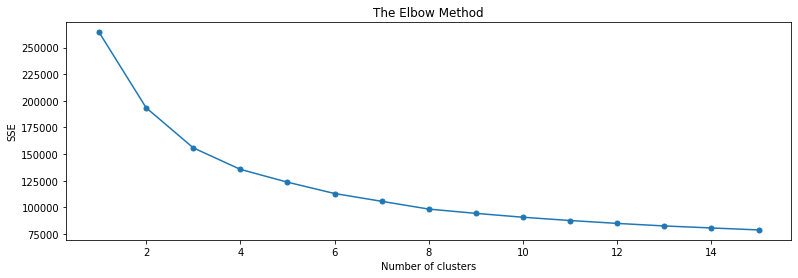

In [31]:
plt.figure(figsize=(13, 4))
plt.plot(range(1, 16), scores, marker='.', markersize=10)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE') 

This analysis is interesting because it suggests that the optimum number of clusters is around 6. But we have many unique people in the dataset.  

What's going on?  Let's take a look at the clusters:

In [32]:
# run the model for the preferred number of clusters

numClusters = 6
normalizedShapesTable = np.reshape(landmarks2D_normlized, [68*2, landmarks2D_normlized.shape[2]]).T

shapesModel = cluster.KMeans(n_clusters=numClusters, n_init=5, random_state=1).fit(normalizedShapesTable[::2,:])
clusterAssignment = shapesModel.predict(normalizedShapesTable)

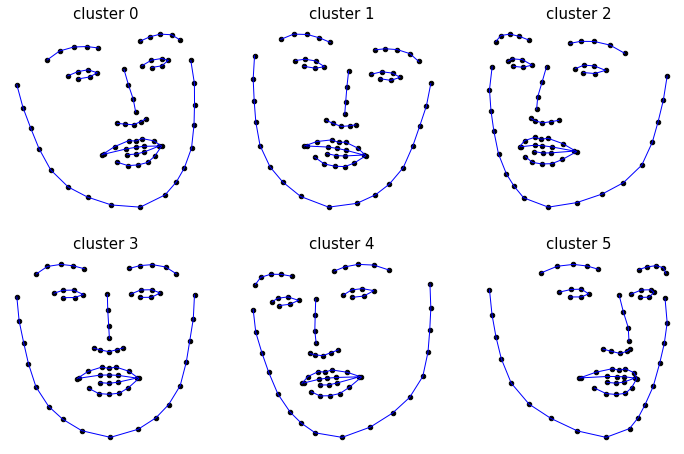

In [33]:
plt.figure(figsize=(12,12))
numRowsAndCols = int(np.ceil(np.sqrt(numClusters)))
for i in range(numClusters):
    plt.subplot(numRowsAndCols,numRowsAndCols,i+1);
    currClusterShape = np.reshape(shapesModel.cluster_centers_[i,:], [68,2])
    plt.scatter(x=currClusterShape[:,0],y=-currClusterShape[:,1],s=20,c='black')
    for conPts in listOfAllConnectedPoints:
        xPts =  currClusterShape[conPts[0]:conPts[-1],0]
        yPts = -currClusterShape[conPts[0]:conPts[-1],1]
        plt.plot(xPts,yPts,c='b',lw=1)
    plt.title('cluster %d' %(i),fontsize=15)
    plt.axis('off')

[   873    874    875 ... 155145 155150 155151]


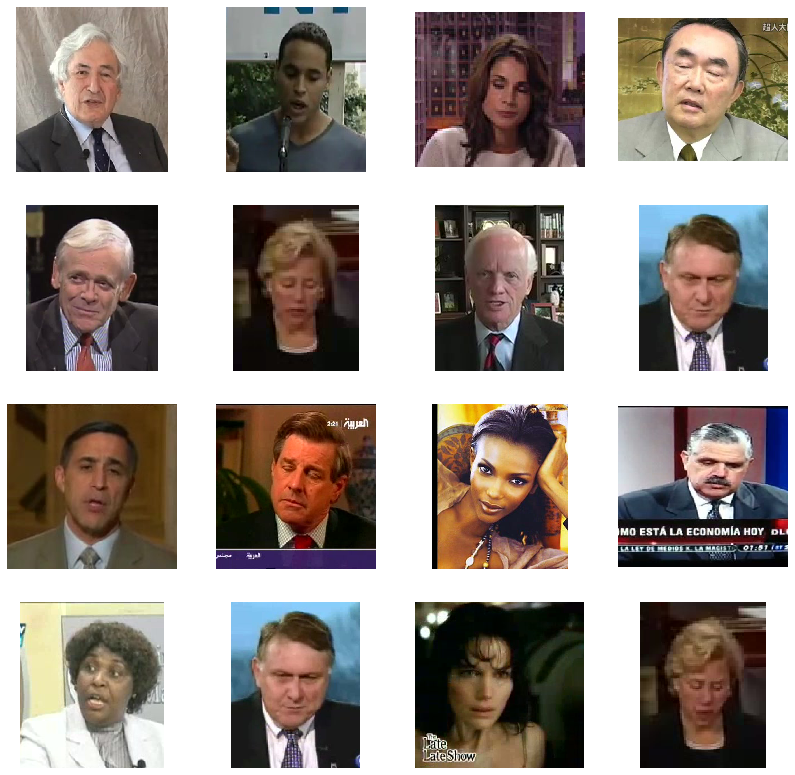

In [34]:
#Cluster 1: Crooked mount and Look Right

#%% show several original images that are assigned to a particular cluster
selectedCluster = 1
numRows = 4; numCols = 4;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
print(shapeIndsAssignedToCluster)
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(14,14))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

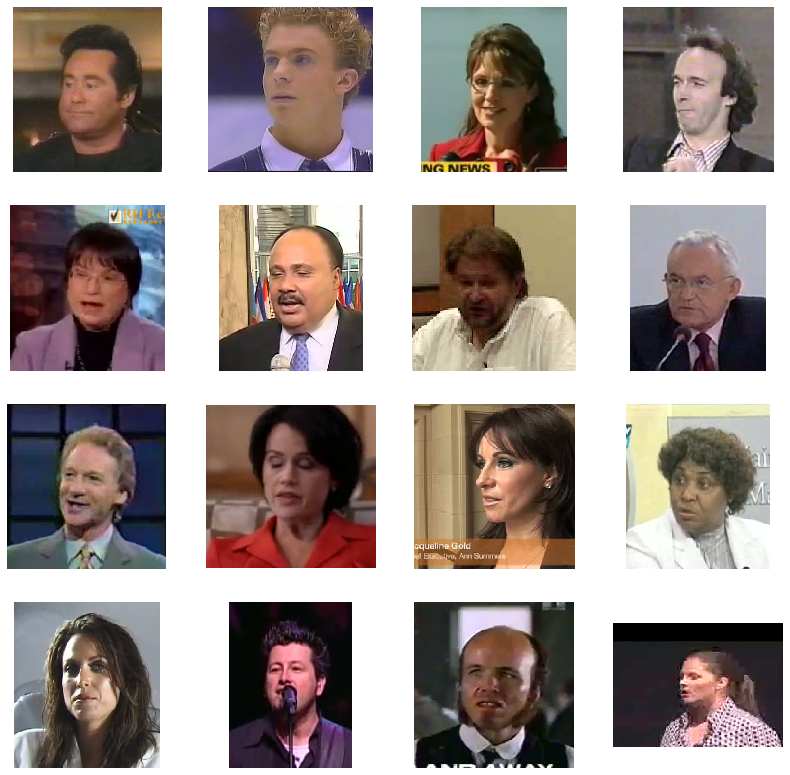

In [35]:
#Cluster 2: Look left

#%% show several original images that are assigned to a particular cluster
selectedCluster = 2
numRows = 4; numCols = 4;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(14,14))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

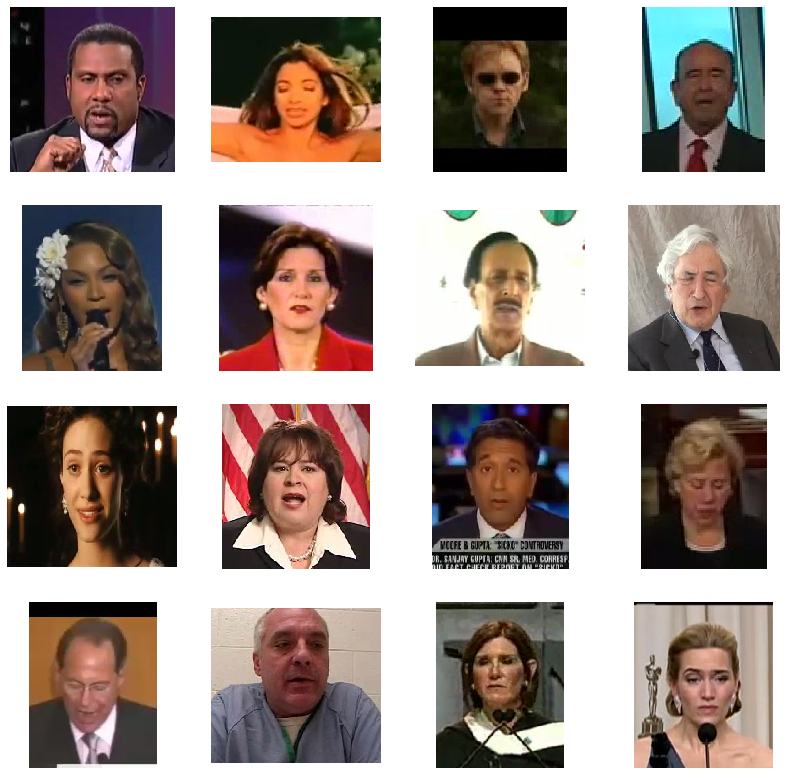

In [36]:
#Cluster 3: Look straight ahead
selectedCluster = 3
numRows = 4; numCols = 4;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(14,14))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

## So great, we can cluster the faces into groups with certain facial expressions or looking into specific directions.  But can we group them by the same person?

### Generate a model with the number of people included in the samples and see if we can group by person, in this case, 374 clusters!!!

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

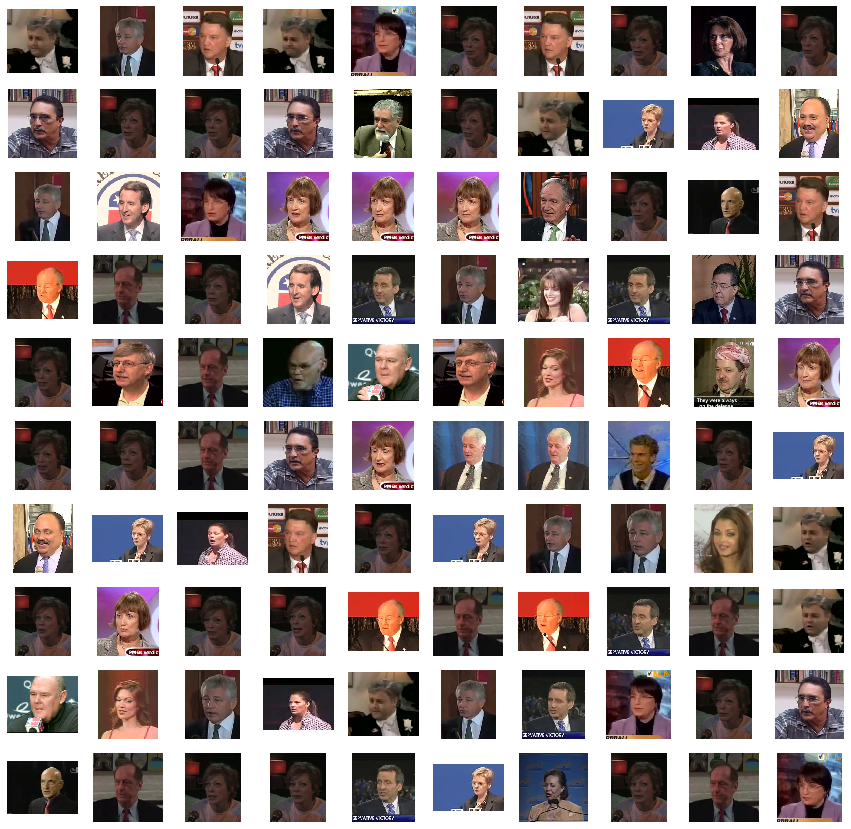

In [37]:
numClusters = categories
normalizedShapesTable = np.reshape(landmarks2D_normlized, [68*2, landmarks2D_normlized.shape[2]]).T

shapesModel = cluster.KMeans(n_clusters=numClusters, n_init=5, random_state=1).fit(normalizedShapesTable[::2,:])
clusterAssignment = shapesModel.predict(normalizedShapesTable)

selectedCluster = 19
numRows = 10; numCols = 10;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(15,15))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

In [38]:
# Clustering grouping
predict = pd.Series(clusterAssignment)

#Save the prediction to file
export_csv = predict.to_csv (r'C:\**\FacesBig\clusterAssignment374.csv', index = None, header=False)

## Create a dataframe to store actual and predicted labels based on the images or masking

In [39]:
# Encode the names of the people into a digital number so that we can compare results. 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(videoDF['personName'])
videoDF['person']=le.transform(videoDF['personName']) 

personList = videoDF.person.unique()

In [40]:
videoDF.head(3)

videoID     personName  imageHeight  imageWidth  videoDuration  \
0  Alison_Lohman_0  Alison_Lohman        228.0       213.0          240.0   
1  Alison_Lohman_1  Alison_Lohman        248.0       201.0           79.0   
2  Alison_Lohman_2  Alison_Lohman        335.0       308.0          136.0   

   averageFaceSize  numVideosForPerson  person  
0        90.150000                 6.0      18  
1       108.417722                 6.0      18  
2       122.161765                 6.0      18

***

This section is computationally slow, only do this if you want to create your own inmemory table.  Otherwise, skip down and just load the "export_dataframe.csv" file at the end.

## ** Begin optional file creation **

In [ ]:
# Get original label
dfCompare=[]
dfCompare =  pd.DataFrame(columns = ['videoIDexpanded','frameNum','actualName'])

In [ ]:
start = 0
numRows = len(videoDF.index)
#print(numRows)

for row in range(0,numRows): 
    frames = int(videoDF['videoDuration'][row])
    person_encode = int((videoDF['person'][row]))
    ID = (videoDF['videoID'][row])
    #print(frames, person_encode)
    
    for individual_frame in range(0,frames):
        #print(individual_frame,person_encode) 
        dfCompare.at[start+individual_frame,'actualName'] = person_encode
        dfCompare.at[start+individual_frame,'videoIDexpanded'] = ID
        dfCompare.at[start+individual_frame,'frameNum'] = int(individual_frame)
        #print(row,individual_frame)
        
    start = start + frames
    #print('new start = ', start)

In [ ]:
# Write the newly created feature and target dataframe to .csv for easier reading
export_csv = dfCompare.to_csv (r'C:\**\FacesBig\export_dataframe.csv', index = None, header=True)

## ** End optional file creation section **
***

If you didn't create the datafrme in memory, load now and continue

In [41]:
dfCompare = pd.read_csv("export_dataframe.csv")

In [42]:
# Add the predicted label from the clustering above

#Run this line if loading the prediciotion
predict=pd.read_csv('clusterAssignment374.csv')

dfCompare['predictedName'] = predict

In [43]:
dfCompare[720:730]

videoIDexpanded  frameNum  actualName  predictedName
720  Alison_Lohman_5        65          18           24.0
721  Alison_Lohman_5        66          18           24.0
722  Alison_Lohman_5        67          18           17.0
723   Kevin_Spacey_0         0         195           17.0
724   Kevin_Spacey_0         1         195           17.0
725   Kevin_Spacey_0         2         195           17.0
726   Kevin_Spacey_0         3         195           17.0
727   Kevin_Spacey_0         4         195           17.0
728   Kevin_Spacey_0         5         195           17.0
729   Kevin_Spacey_0         6         195           17.0

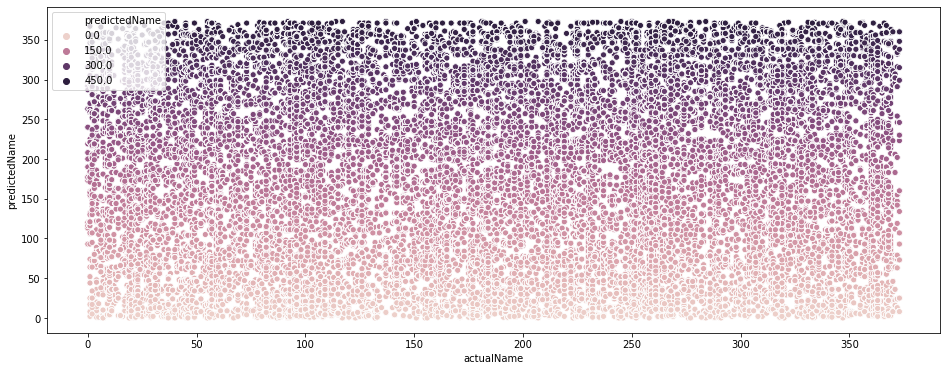

In [44]:
plt.figure(figsize=(16, 6))
sns.scatterplot(dfCompare['actualName'],dfCompare['predictedName'],hue=dfCompare["predictedName"])

## Let's see what some of these clusters look like

In [45]:
# Get the user to pick a person
who =  int(input("Enter an integer between 0 and 379 ") )

# Get the row numbers for all actual chosen person
index = dfCompare.loc[dfCompare['actualName'] == who].index

#Grab the maximum for making the range
indexMax = max(index)

#Create an empty dataframe for holding the data to make a pie for each person of the prediction breakdowns
dfPie = pd.DataFrame(columns = ['singlePredict'])

Enter an integer between 0 and 26 17


In [46]:
for i in range(0,indexMax):
    dfPie.at[i,'singlePredict'] = dfCompare['predictedName'][i]  

In [47]:
# Find the most common group for images belonging to the same chosen group
predPerson = dfPie['singlePredict'].value_counts().keys().tolist()
count = dfPie['singlePredict'].value_counts().tolist()
mostCommon = predPerson[who]
print(predPerson)
print(count)
print(mostCommon)

[250.0, 21.0, 245.0, 344.0, 179.0, 183.0, 93.0, 139.0, 137.0, 49.0, 264.0, 234.0, 184.0, 223.0, 354.0, 77.0, 346.0, 257.0, 242.0, 154.0, 312.0, 323.0, 110.0, 356.0, 168.0, 299.0, 171.0, 83.0, 103.0, 64.0, 202.0, 7.0, 2.0, 311.0, 360.0, 227.0, 293.0, 269.0, 285.0, 322.0, 95.0, 313.0, 57.0, 338.0, 61.0, 305.0, 191.0, 29.0, 4.0, 244.0, 214.0, 173.0, 209.0, 111.0, 254.0, 330.0, 155.0, 358.0, 233.0, 98.0, 91.0, 206.0, 337.0, 132.0, 60.0, 240.0, 294.0, 228.0, 186.0, 78.0, 199.0, 318.0, 295.0, 336.0, 144.0, 278.0, 222.0, 201.0, 347.0, 248.0, 160.0, 331.0, 67.0, 208.0, 36.0, 180.0, 218.0, 54.0, 122.0, 41.0, 30.0, 224.0, 66.0, 0.0, 10.0, 161.0, 309.0, 280.0, 170.0, 151.0, 320.0, 177.0, 17.0, 284.0, 328.0, 32.0, 135.0, 24.0, 203.0, 56.0, 221.0, 200.0, 304.0, 133.0, 226.0, 150.0, 308.0, 225.0, 145.0, 340.0, 13.0, 153.0, 11.0, 86.0, 365.0, 258.0, 130.0, 147.0, 205.0, 96.0, 262.0, 70.0, 102.0, 46.0, 92.0, 217.0, 58.0, 106.0, 237.0, 164.0, 289.0, 216.0, 212.0, 300.0, 68.0, 73.0, 207.0, 97.0, 12.0, 1

In [48]:
numPredictionsForPerson = len(dfPie)

In [49]:
percent = []

for z in range (0,len(count)):
        new = round((count[z]/numPredictionsForPerson)*100,1)
        percent.append(new)
        
print(percent)        

[1.7, 1.4, 1.4, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.1, 1.0, 1.0, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,

# Pie plot representing the number of different faces for a known series of frames specific to one person


With 2 % accuracy.


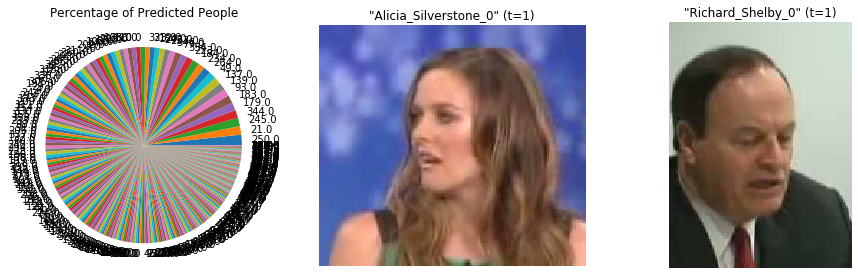

In [51]:
#Grab the most common person from the list (first position)

#Create a figure from the pie chart, then a frame from the known person and a frame from the most common predicted match 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
fig.tight_layout()

new = round((count[0]/numPredictionsForPerson)*100)
accuracyCluster = (count[0]/numPredictionsForPerson)
print('With',new,'% accuracy.')
ax1.pie(percent,labels =predPerson)
ax1.set_title('Percentage of Predicted People', fontsize=12)

#Show image from the labelled group 0
yyy = videoDF.loc[videoDF['person'] == who]
videoID = yyy['videoID'].values[0]
videoFile = np.load(fullPaths[videoID])
colorImages = videoFile['colorImages'] # arrays of the image colour values
framesToShowFromVideo = 1
selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)) #.astype(int)
ax2.imshow(colorImages[:,:,:,selectedFrames])
ax2.set_title('"%s" (t=%d)' %(videoID,framesToShowFromVideo), fontsize=12)
ax2.set_axis_off()


# pick an image from all those labelled as the most common group and see if you get the right person 

# Show image from the most popular group in the cluster (maybe it will match?)    
zzz = dfCompare.loc[dfCompare['predictedName'] == mostCommon]

numBelongingToChosenClass = zzz.videoIDexpanded.count()

originalPerson = zzz['actualName'].value_counts().keys().tolist()
countOrig = zzz['actualName'].value_counts().tolist()
mostCommonOrig = originalPerson[0]

# grab just the rows in a dataframe of the most common originally properly labelled person
zz2 = zzz.loc[dfCompare['actualName'] == mostCommonOrig]


# get the filename for the represented person
videoID2 = zz2['videoIDexpanded'].values[who]
#get the frame number for that labelling
frameID2 = 1 

videoFile = np.load(fullPaths[videoID2])
colorImages = videoFile['colorImages'] # arrays of the image colour values

framesToShowFromVideo = frameID2
selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)) #.astype(int)

ax3.imshow(colorImages[:,:,:,selectedFrames])
ax3.set_title('"%s" (t=%d)' %(videoID2,framesToShowFromVideo), fontsize=12)
ax3.set_axis_off() 

So, in this case, the clustering algorithm did not properly match the people. 



# Classification Analysis

In this section, we will create a dataframe of features to use in classification regressions.  
The dataframe consists of columns each holding one of the cordinates (x then y) for each of the landmarks points.

The theory is that the unique patterns of the coordinates will distinguish individual people because the relationship (weights) between all the points are unique for each individual regardless of the expression the direction they are looking

In [52]:
#import classifier libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [53]:
# collect features from the normalized landmarks
XClass = normalizedShapesTable

#c=Collect targets (y) from the encoded names
y_Class = dfCompare.iloc[:,2].values 
y_Class=y_Class.astype('int')

print(XClass.shape)
print(y_Class.shape)

(155560, 136)
(155560,)


In [54]:
#Create new train and test arrays
x_columns=136

XclassDF = pd.DataFrame(XClass)
XclassDF.shape

(155560, 136)

In [55]:
#adjust the data type
X_Class = XclassDF.iloc[:,0:x_columns].values

In [56]:
#Create train and test sets
X_trainClass, X_testClass, y_trainClass, y_testClass = train_test_split(X_Class, y_Class, test_size=0.25, random_state=0)

print(X_trainClass.shape)
print(y_trainClass.shape)
print(X_testClass.shape)
print(y_testClass.shape)

(116670, 136)
(116670,)
(38890, 136)
(38890,)


In [57]:
# Create a dictionary of the models to be run
models=[("LR", LogisticRegression()), ("DTC", DecisionTreeClassifier()), 
        ("KNC", KNeighborsClassifier()), ("SVC", SVC()), ("GNB", GaussianNB()), 
        ("RFC", RandomForestClassifier())]

#initialize scores
accuracyLR = 0
accuracyDTC = 0
accuracyKNN = 0
accuracySVC = 0
accuracyGNB = 0
accuracyRFC = 0

## LogisticRegression

In [ ]:
# Not running yet
# LR =LogisticRegression()
print('LR model created')
LR.fit(X_trainClass, y_trainClass)
print('LR model fit')
predictionsLR= LR.predict(X_testClass)
accuracyLR=(accuracy_score(y_testClass, predictionsLR))
print(accuracyLR)

LR model created


## Decision Tree Analysis 

In [58]:
DTC =DecisionTreeClassifier()
print('DTC model created')
DTC.fit(X_trainClass, y_trainClass)
print('DTC model fit')
predictionsDTC= DTC.predict(X_testClass)
accuracyDTC=(accuracy_score(y_testClass, predictionsDTC))
print(accuracyDTC)

DTC model created
DTC model fit
0.5467215222422217


## K-Mean Nearest Neighbours 

In [67]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_trainClass, y_trainClass)
predictionsKNN= knn.predict(X_testClass)
accuracyKNC=(accuracy_score(y_testClass, predictionsKNN))
print(accuracyKNC)

0.9415788120339419


## Support Vector Classification (SVC)

In [2]:
# Not running yet
#modelSVC = SVC(max_iter=10)
#modelSVC.fit(X_trainClass, y_trainClass)
#predictionsSVC= modelSVC.predict(X_testClass)
#accuracySVC=(accuracy_score(y_testClass, predictionsSVC))
#print(accuracySVC)

## Gaussian Naive Bayes (GNB)

In [60]:
GNB =GaussianNB()
print('GNB model created')
GNB.fit(X_trainClass, y_trainClass)
print('GNB model fit')
predictionsGNB= GNB.predict(X_testClass)
accuracyGNB=(accuracy_score(y_testClass, predictionsGNB))
print(accuracyGNB)

GNB model created
GNB model fit
0.1717665209565441


## RandomForestClassifier (RFC)

In [61]:
RFC =RandomForestClassifier()
print('RFC model created')
RFC.fit(X_trainClass, y_trainClass)
print('RFC model fit')
predictionsRFC= RFC.predict(X_testClass)
accuracyRFC=(accuracy_score(y_testClass, predictionsRFC))
print(accuracyRFC)

RFC model created
GRFCNB model fit
0.7360246850089998


## Save and display the results of the Classification, Clustering and Neural Network Models 

In [62]:
# List of all methods used in comparison
modelList=["LR","DTC","KNC","SVC","GNB","RFC",'Cluster',"ANN_2D","ANN_3D"]

In [63]:
modelList

['LR', 'DTC', 'KNC', 'SVC', 'GNB', 'RFC', 'Cluster', 'ANN_2D', 'ANN_3D']

In [64]:
# Load ANN scores from supplementary notebook 
maxANN_2D = 0.859
maxANN_3D = 0.886


In [65]:
# Create a list with the scores with each of the methods in this notebook
allScores = [accuracyLR, accuracyDTC, accuracyKNC, accuracySVC, accuracyGNB, accuracyRFC, accuracyCluster, maxANN_2D, maxANN_3D]

(0, 1)

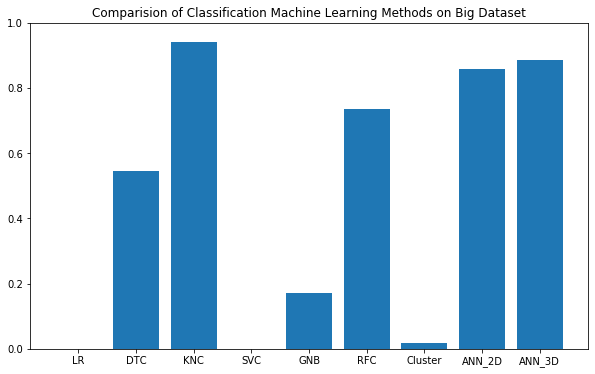

In [66]:
plt.figure(figsize=(10,6))
plt.bar(modelList,allScores)
plt.title('Comparision of Classification Machine Learning Methods on Big Dataset')
plt.ylim(0,1)

## So what's next? How about a neural network?

See the next Jupyter notebook 'YouTubeFacialRecognitionBig-ANN.IPYNB' for setting up and running a neural network on the 2D and 3D landmarks